<a href="https://colab.research.google.com/github/swaingotnochill/Automation/blob/main/TrafficSignRecognization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1XQvqXE-cy-seaMojF0EeP0QoOVtV9NeL')

     |████████████████████████████████| 71kB 1.6MB/s 


In [2]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import os


In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: meviole
Your Kaggle Key: ··········


  2%|▏         | 12.0M/612M [00:00<00:05, 112MB/s]

100%|██████████| 612M/612M [00:03<00:00, 180MB/s]


In [5]:
train_data_path = './gtsrb-german-traffic-sign/Train'
classes = (os.listdir(train_data_path))
len(classes)

43

In [6]:
print(os.listdir(train_data_path + '/1')[:10])

['00001_00063_00008.png', '00001_00070_00027.png', '00001_00028_00011.png', '00001_00043_00016.png', '00001_00054_00019.png', '00001_00071_00017.png', '00001_00021_00024.png', '00001_00025_00027.png', '00001_00049_00019.png', '00001_00060_00023.png']


In [7]:
test_dir_path ='../input/gtsrb-german-traffic-sign/Test'


In [8]:
Data_dir = './'

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline


In [10]:
import torchvision.transforms as tt

In [12]:
img_size = 32
batch_size = 128
stats = (0.5,0.5,0.5), (0.5,0.5,0.5)

train_ds = ImageFolder(train_data_path, transform=tt.Compose([
    tt.Resize(img_size),
    tt.RandomCrop(32, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats)

]))

In [13]:
len(train_ds)

39209

In [14]:
import torch.utils.data as data

In [16]:
val_size = 5000
train_size = len(train_ds) - val_size
train_data, val_data = data.random_split(train_ds, [train_size, val_size])

In [22]:
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers= 3, pin_memory=True)
val_dl = DataLoader(val_data, batch_size=val_size, num_workers=3, pin_memory=True)

In [23]:
def denorm(img_tensor):
    return img_tensor*stats[0][1] + stats[0][0]

In [24]:
from torchvision.utils import make_grid

In [25]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))
    
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
        

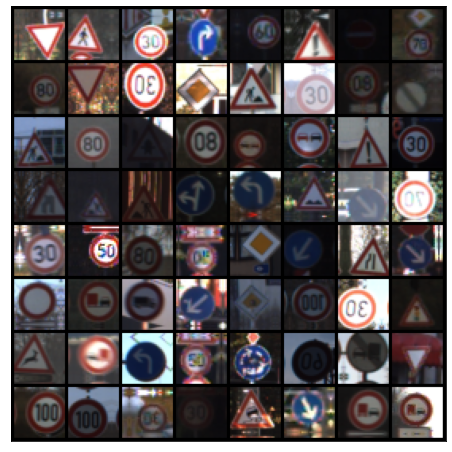

In [26]:
show_batch(train_dl)

In [27]:

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
device = get_default_device()
device

device(type='cuda')

In [29]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [30]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [31]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc':epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print('Epoch [{}], last_lr: {:.5f}, train_loss:{:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [32]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [33]:
model =to_device(ResNet9(3, 43), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [34]:
from tqdm.notebook import tqdm

In [35]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [37]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.007199999876320362, 'val_loss': 3.759181261062622}]

In [38]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_fun = torch.optim.Adam

In [39]:
history += fit_one_cycle(epochs, max_lr,model,  train_dl, val_dl, grad_clip= grad_clip, weight_decay = weight_decay, opt_func= opt_fun)


Epoch [0], last_lr: 0.00279, train_loss:1.5711, val_loss: 0.9322, val_acc: 0.7590



Epoch [1], last_lr: 0.00759, train_loss:0.3541, val_loss: 0.8112, val_acc: 0.7822



Epoch [2], last_lr: 0.01000, train_loss:0.2153, val_loss: 0.2402, val_acc: 0.9222



Epoch [3], last_lr: 0.00950, train_loss:0.1121, val_loss: 0.1433, val_acc: 0.9556



Epoch [4], last_lr: 0.00812, train_loss:0.0733, val_loss: 0.1486, val_acc: 0.9632



Epoch [5], last_lr: 0.00611, train_loss:0.0499, val_loss: 0.0442, val_acc: 0.9862



Epoch [6], last_lr: 0.00389, train_loss:0.0308, val_loss: 0.0232, val_acc: 0.9942



Epoch [7], last_lr: 0.00188, train_loss:0.0144, val_loss: 0.0091, val_acc: 0.9962



Epoch [8], last_lr: 0.00050, train_loss:0.0060, val_loss: 0.0056, val_acc: 0.9982



Epoch [9], last_lr: 0.00000, train_loss:0.0028, val_loss: 0.0043, val_acc: 0.9988


In [41]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

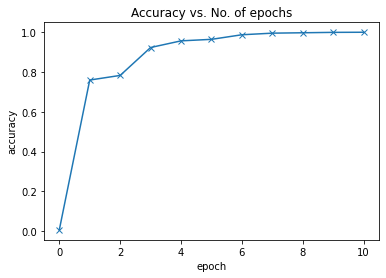

In [43]:
plot_accuracies(history)

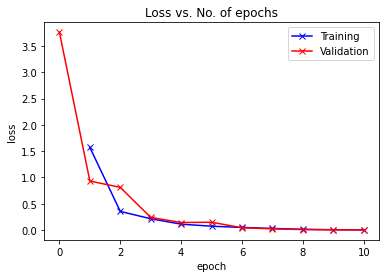

In [44]:
plot_losses(history)

In [45]:
data_dir="../input/gtsrb-german-traffic-sign/Test"

In [47]:
#importing test dataset
import pandas as pd
dataset=pd.read_csv("./gtsrb-german-traffic-sign/Test.csv")
y_test=dataset['Path'].values
labels=dataset['ClassId'].values

In [82]:
truelabel = torch.tensor(labels)
truelabel

tensor([16,  1, 38,  ...,  6,  7, 10])

In [62]:
y_test

array(['Test/00000.png', 'Test/00001.png', 'Test/00002.png', ...,
       'Test/12627.png', 'Test/12628.png', 'Test/12629.png'], dtype=object)

In [63]:
from PIL import Image

In [139]:
data=[]
path = "./gtsrb-german-traffic-sign/"
#print(path)
Class=os.listdir(path)
for a in y_test:
    img = Image.open(path+a)
    data_array=tt.ToTensor()
    data_shape=data_array(img)
    img_PIL = tt.ToPILImage()(data_shape)
    img_PIL = tt.Resize([32,32])(img_PIL)
    img_PIL = tt.ToTensor()(img_PIL)
    
    data.append(img_PIL)
            

In [140]:
test_dataset = []
for i in range(len(data)):
  test_dataset.append([data[i],truelabel[i]])

In [143]:
test_dataset= DataLoader(test_dataset, batch_size)

In [144]:

test_dl = DeviceDataLoader(test_dataset, device)



In [145]:
result = evaluate(model, test_dl)

In [146]:
result

{'val_acc': 0.06296797841787338, 'val_loss': 17.39156723022461}

In [ ]:
#for images, labels in test_dl : 
 # images = to_device(images.unsqueeze(0), )

In [127]:
 # def check_accuracy(loader, model):
    #num_correct = 0
    #num_samples = 0
    #for x, y in tqdm(loader):
     # y = to_device(y, device)
      #xb = to_device(x.unsqueeze(0), device)
      #scores = model(xb)
      #probs = F.softmax(scores, dim = 1)
      #_, predictions  =
      
      #num_correct += (predictions == y).sum()
      #num_samples += predictions.size(0)
    #print(num_correct/num_samples)
    #return torch.tensor(torch.sum(preds==labels)/len(preds))
    
  

In [128]:
#%%time 
#check_accuracy(test_dl, model)


tensor(0.0629, device='cuda:0')


In [148]:
!pip install jovian --upgrade --quiet
import jovian
jovian.commit(project='TrafficSignRecognization', environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/swaingotnochill/trafficsignrecognization


'https://jovian.ai/swaingotnochill/trafficsignrecognization'